In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Resize
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import random
import cv2
from scipy.stats import pearsonr
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        
        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"Root directory {root_dir} does not exist. Please check the path.")
        
        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            if not os.path.exists(class_dir):
                raise FileNotFoundError(f"Class directory {class_dir} does not exist. Expected classes: {self.classes}")
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(self.classes.index(label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label, img_path

In [4]:
# Define transformations
transform = transforms.Compose([
    Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Define dataset paths
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

if not os.path.exists(train_dir):
    train_dir = './data/Training'
    test_dir = './data/Testing'
    print(f"Kaggle dataset not found. Using local paths: {train_dir}, {test_dir}")

# Create datasets
try:
    full_train_dataset = BrainTumorDataset(root_dir=train_dir, transform=transform)
    test_dataset = BrainTumorDataset(root_dir=test_dir, transform=transform)
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the dataset is available at the specified path or update the path to your local dataset.")
    raise

# Split training dataset into 80% train and 20% validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

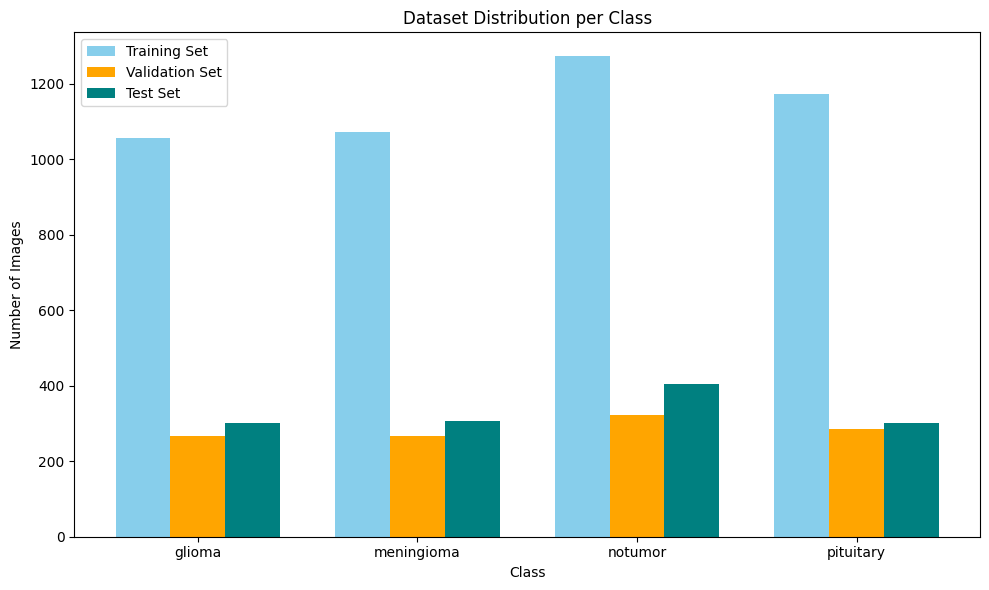

In [5]:
# Function to compute class distribution
def compute_class_distribution(dataset, classes):
    counts = [0] * len(classes)
    for _, label, _ in dataset:
        counts[label] += 1
    return counts

# Compute class distributions
train_counts = compute_class_distribution(train_dataset, full_train_dataset.classes)
val_counts = compute_class_distribution(val_dataset, full_train_dataset.classes)
test_counts = compute_class_distribution(test_dataset, test_dataset.classes)

# Create bar plot for dataset distribution
plt.figure(figsize=(10, 6))
x = np.arange(len(full_train_dataset.classes))  # Class indices
bar_width = 0.25  # Width of each bar

# Plot bars for each dataset
plt.bar(x - bar_width, train_counts, bar_width, label='Training Set', color='skyblue')
plt.bar(x, val_counts, bar_width, label='Validation Set', color='orange')
plt.bar(x + bar_width, test_counts, bar_width, label='Test Set', color='teal')

# Customize plot
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution per Class')
plt.xticks(x, full_train_dataset.classes)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

In [6]:
class HybridEfficientNetMobileNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
        efficientnet_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()
        
        self.mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')
        mobilenet_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Identity()
        
        self.attention = nn.Sequential(
            nn.Linear(efficientnet_features + mobilenet_features, 256),
            nn.ReLU(),
            nn.Linear(256, efficientnet_features + mobilenet_features),
            nn.Sigmoid()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(efficientnet_features + mobilenet_features, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, num_classes)
        )
        
        self.feature_maps_mobilenet = None
        self.feature_maps_efficientnet = None
        self.attention_weights = None
        self.efficientnet_features_dim = efficientnet_features

    def forward(self, x):
        eff_features = self.efficientnet(x)
        mob_features = self.mobilenet(x)
        combined_features = torch.cat((eff_features, mob_features), dim=1)
        self.attention_weights = self.attention(combined_features)
        weighted_features = combined_features * self.attention_weights
        output = self.classifier(weighted_features)
        return output

In [7]:
# Initialize model
model = HybridEfficientNetMobileNet(num_classes=len(full_train_dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Training parameters
num_epochs = 20
train_acc_history = []
val_acc_history = []
train_precision_history = []
val_precision_history = []
train_f1_history = []
val_f1_history = []
train_loss_history = []
val_loss_history = []
best_val_f1 = 0.0
early_stop_counter = 0
early_stop_patience = 4

# Checkpoint function
def save_checkpoint(state, filename="best_model.pth"):
    torch.save(state, filename)

In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss_train = 0.0
    y_true_train = []
    y_pred_train = []

    for inputs, labels, _ in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss_train += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())

    train_loss_epoch = running_loss_train / len(train_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='weighted', zero_division=0)
    train_acc_epoch = 100 * (np.array(y_true_train) == np.array(y_pred_train)).sum() / len(y_true_train)
    
    train_loss_history.append(train_loss_epoch)
    train_acc_history.append(train_acc_epoch)
    train_precision_history.append(precision * 100)
    train_f1_history.append(f1 * 100)

    model.eval()
    running_loss_val = 0.0
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(predicted.cpu().numpy())

    val_loss_epoch = running_loss_val / len(val_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_val, y_pred_val, average='weighted', zero_division=0)
    val_acc_epoch = 100 * (np.array(y_true_val) == np.array(y_pred_val)).sum() / len(y_true_val)
    
    val_loss_history.append(val_loss_epoch)
    val_acc_history.append(val_acc_epoch)
    val_precision_history.append(precision * 100)
    val_f1_history.append(f1 * 100)

    if np.isnan(f1) or np.isinf(f1):
        print(f"Warning: Invalid F1-score ({f1}) at epoch {epoch+1}. Skipping scheduler step.")
    else:
        scheduler.step(f1)
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    if f1 > best_val_f1 and not (np.isnan(f1) or np.isinf(f1)):
        best_val_f1 = f1
        save_checkpoint({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss_epoch,
        })
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc_epoch:.2f}%')
    print(f'Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.2f}%')

Learning Rate: 0.001000
Epoch [1/20], Train Loss: 0.4090, Train Acc: 86.28%
Val Loss: 0.2921, Val Acc: 91.08%
Learning Rate: 0.001000
Epoch [2/20], Train Loss: 0.2105, Train Acc: 93.78%
Val Loss: 0.1928, Val Acc: 94.84%
Learning Rate: 0.001000
Epoch [3/20], Train Loss: 0.1904, Train Acc: 94.70%
Val Loss: 0.1896, Val Acc: 93.44%
Learning Rate: 0.001000
Epoch [4/20], Train Loss: 0.1303, Train Acc: 96.24%
Val Loss: 0.2541, Val Acc: 94.84%
Learning Rate: 0.001000
Epoch [5/20], Train Loss: 0.1168, Train Acc: 96.87%
Val Loss: 0.1061, Val Acc: 96.94%
Learning Rate: 0.001000
Epoch [6/20], Train Loss: 0.1136, Train Acc: 96.89%
Val Loss: 0.1979, Val Acc: 94.75%
Learning Rate: 0.001000
Epoch [7/20], Train Loss: 0.0737, Train Acc: 97.90%
Val Loss: 0.1136, Val Acc: 97.55%
Learning Rate: 0.001000
Epoch [8/20], Train Loss: 0.0624, Train Acc: 98.05%
Val Loss: 0.2312, Val Acc: 94.14%
Learning Rate: 0.001000
Epoch [9/20], Train Loss: 0.0635, Train Acc: 98.40%
Val Loss: 0.1178, Val Acc: 97.11%
Learning R

In [9]:
model.eval()
running_loss_test = 0.0
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for inputs, labels, _ in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_test += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

test_loss = running_loss_test / len(test_loader)
precision, recall, f1, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='weighted', zero_division=0)
test_acc = 100 * (np.array(y_true_test) == np.array(y_pred_test)).sum() / len(y_true_test)

# Final Classification Report (Test Set)
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_dataset.classes, digits=4))


Test Classification Report:
              precision    recall  f1-score   support

      glioma     1.0000    0.9367    0.9673       300
  meningioma     0.9590    0.9935    0.9759       306
     notumor     0.9975    0.9901    0.9938       405
   pituitary     0.9582    0.9933    0.9755       300

    accuracy                         0.9794      1311
   macro avg     0.9787    0.9784    0.9781      1311
weighted avg     0.9801    0.9794    0.9794      1311



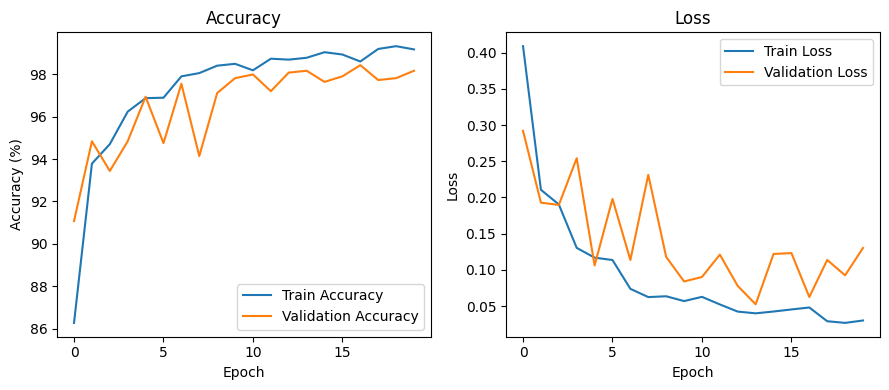

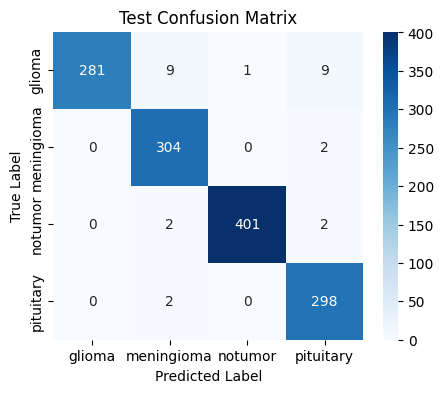

In [10]:
# Plot metrics
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix (Test Set)
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
# Part 7: History and Execution
# Create history dictionary
history = {
    'train_acc': train_acc_history,
    'val_acc': val_acc_history,
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    'train_precision': train_precision_history,
    'val_precision': val_precision_history,
    'train_f1': train_f1_history,
    'val_f1': val_f1_history,
    'test_acc': test_acc,
    'test_loss': test_loss,
    'test_precision': precision * 100,
    'test_f1': f1 * 100
}

# Main function to execute all parts
def train_and_evaluate_model():
    # Note: All parts are assumed to be executed in sequence as defined above
    return model, history

# Call the function
model, history = train_and_evaluate_model()

# sesh

In [12]:
def get_gradcam_heatmap(model, img_tensor, target_class, model_type='mobilenet'):
    model.eval()
    if model_type == 'mobilenet':
        conv_layer = model.mobilenet.features[-1]
        feature_map_attr = 'feature_maps_mobilenet'
    elif model_type == 'efficientnet':
        conv_layer = model.efficientnet.features[-1]
        feature_map_attr = 'feature_maps_efficientnet'
    else:
        raise ValueError("model_type must be 'mobilenet' or 'efficientnet'")
    
    gradients = []
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    def forward_hook(module, input, output):
        setattr(model, feature_map_attr, output)
    
    handle_backward = conv_layer.register_backward_hook(backward_hook)
    handle_forward = conv_layer.register_forward_hook(forward_hook)

    output = model(img_tensor.unsqueeze(0).to(device))
    model.zero_grad()
    output[:, target_class].backward()
    
    gradients = gradients[0].cpu().data.numpy()[0]
    feature_maps = getattr(model, feature_map_attr).cpu().data.numpy()[0]
    
    if feature_maps.ndim != 3:
        raise ValueError(f"Expected feature_maps to have 3 dimensions [C, H, W], but got {feature_maps.shape}")
    
    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * feature_maps[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_tensor.shape[2], img_tensor.shape[1]))
    heatmap = cam - np.min(cam)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    
    handle_forward.remove()
    handle_backward.remove()
    return heatmap

def compute_heatmap_iou(heatmap1, heatmap2, threshold=0.5):
    binary1 = (heatmap1 > threshold).astype(np.uint8)
    binary2 = (heatmap2 > threshold).astype(np.uint8)
    intersection = np.logical_and(binary1, binary2).sum()
    union = np.logical_or(binary1, binary2).sum()
    return intersection / (union + 1e-8)

In [24]:
def display_images_per_class(test_dataset):
    classes = test_dataset.classes
    for class_idx, class_name in enumerate(classes):
        # Collect indices for the class
        class_indices = [i for i, label in enumerate(test_dataset.labels) if label == class_idx]
        
        if len(class_indices) < 2:
            print(f"Warning: Only {len(class_indices)} images found for class {class_name} in test dataset.")
            continue
        
        # Select two images
        selected_indices = random.sample(class_indices, 2)
        
        # Show 2x2 grid with Original and Combined Grad-CAM for all classes
        plt.figure(figsize=(6, 6))
        
        for i, idx in enumerate(selected_indices):
            img, _, _ = test_dataset[idx]
            output = model(img.unsqueeze(0).to(device))
            pred_class = output.argmax(dim=1).item()
            mobilenet_heatmap = get_gradcam_heatmap(model, img, pred_class, model_type='mobilenet')
            efficientnet_heatmap = get_gradcam_heatmap(model, img, pred_class, model_type='efficientnet')
            combined_heatmap = (mobilenet_heatmap + efficientnet_heatmap) / 2
            
            img_np = img.permute(1, 2, 0).detach().cpu().numpy()
            img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np) + 1e-8)
            img_np = (img_np * 255).astype(np.uint8)
            
            # Display Grad-CAM only for non-"notumor" classes
            plt.subplot(2, 2, i*2+2)
            if class_name != 'notumor':
                mobilenet_heatmap = get_gradcam_heatmap(model, img, pred_class, model_type='mobilenet')
                efficientnet_heatmap = get_gradcam_heatmap(model, img, pred_class, model_type='efficientnet')
                combined_heatmap = (mobilenet_heatmap + efficientnet_heatmap) / 2
                plt.imshow(img_np)  # Show original image as background
                plt.imshow(combined_heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
                plt.title("Combined Grad-CAM")
            else:
                plt.imshow(img_np)
                plt.title("Normal")
            plt.axis('off')
        
        plt.suptitle(f"Class: {class_name}")
        plt.tight_layout()
        plt.show()

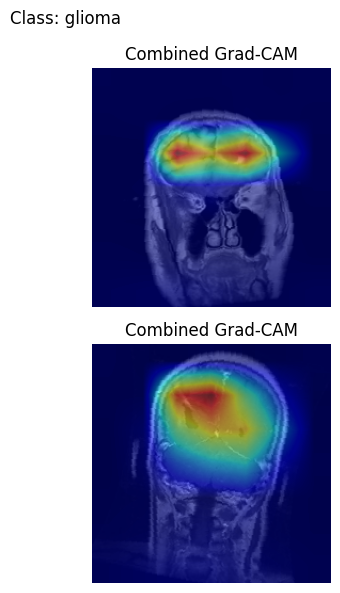

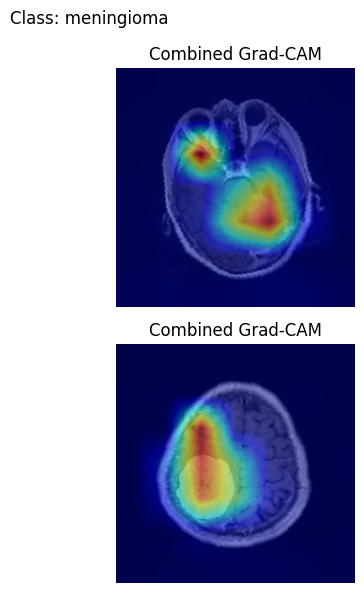

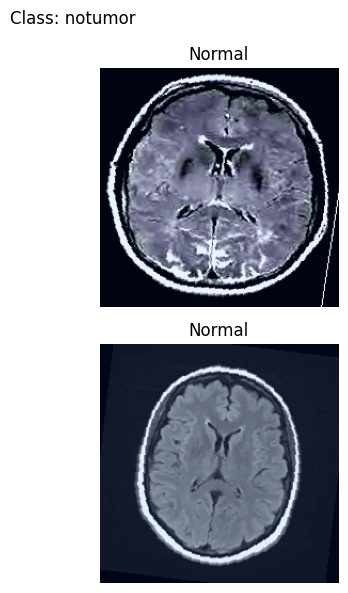

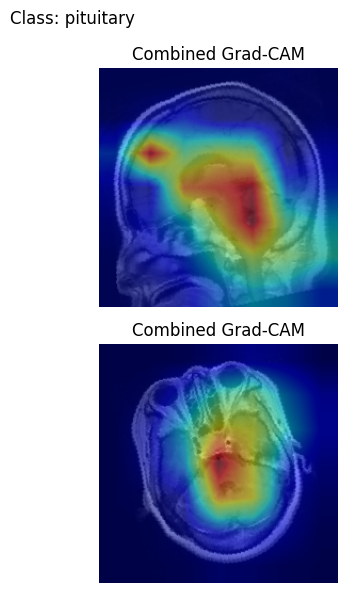

In [25]:
def train_and_evaluate_model():
    # All previous code sections are assumed to be defined here
    # Execute data loading, model training, evaluation, and visualization
    display_images_per_class(test_dataset)
    
    # Create history dictionary
    history = {
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_precision': train_precision_history,
        'val_precision': val_precision_history,
        'train_f1': train_f1_history,
        'val_f1': val_f1_history,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'test_precision': precision * 100,
        'test_f1': f1 * 100
    }

    return model, history

# Call the function to execute
model, history = train_and_evaluate_model()